In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')

from functions.split_dataset import split_dataset, prepare_to_eval
from functions.create_model import create_model_bilstmcrf

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from seqeval.metrics import f1_score, classification_report, accuracy_score
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow_addons.losses import SigmoidFocalCrossEntropy

2022-08-18 00:57:59.124793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 00:57:59.124846: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-08-18 00:58:10.788268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-18 00:58:11.409183: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-18 00:58:11.409525: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (meilux): /proc/driver/nvidia/version does not exist


In [3]:
dataset_path = '../../data/restauranttrain.bio.csv'

df = pd.read_csv(dataset_path, sep="\t", skip_blank_lines=False)
df[:20]

,Tag,Text
0,B-Rating,2
1,I-Rating,start
2,O,restaurants
3,O,with
4,B-Amenity,inside
5,I-Amenity,dining
6,NaN,NaN
7,O,34
8,NaN,NaN
9,B-Rating,5


In [4]:
id_list = []
id = 0

def isNaN(string):
    return string != string

for tag, text in zip(df['Tag'], df['Text']):
    if isNaN(tag):
        id += 1
    id_list.append(id)

df['id'] = id_list
df = df.dropna()
df[:20]

,Tag,Text,id
0,B-Rating,2,0
1,I-Rating,start,0
2,O,restaurants,0
3,O,with,0
4,B-Amenity,inside,0
5,I-Amenity,dining,0
7,O,34,1
9,B-Rating,5,2
10,I-Rating,star,2
11,O,resturants,2


In [5]:
df.head()

,Tag,Text,id
0,B-Rating,2,0
1,I-Rating,start,0
2,O,restaurants,0
3,O,with,0
4,B-Amenity,inside,0


In [6]:
df['Text'].astype(str)

0                  2
1              start
2        restaurants
3               with
4             inside
            ...     
78179            you
78180           look
78181            for
78182              a
78183     restaurant
Name: Text, Length: 70525, dtype: object

In [7]:
all_documents = list(set(df["id"].values))
num_documents = len(all_documents)

all_tags = list(set(df["Tag"].values))
NUM_TAGS = len(all_tags)

all_words = list(set(df["Text"].values))
VOCAB_SIZE = len(all_words)

print(f'Quantidade de documentos: {num_documents}')
print(f'Number of unique words: {VOCAB_SIZE}')
print(f'Quantidade de tags: {NUM_TAGS}')

Quantidade de documentos: 7660
Number of unique words: 3804
Quantidade de tags: 17


<AxesSubplot:>

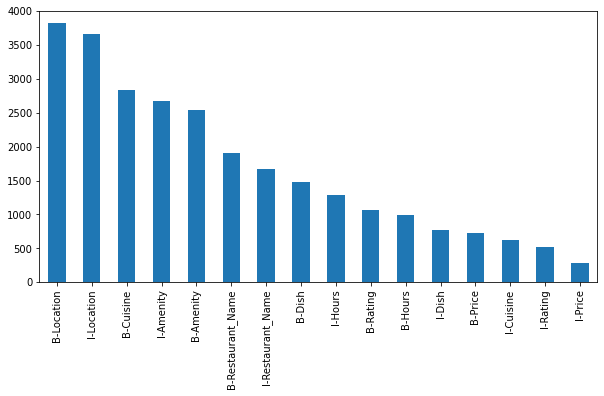

In [8]:
df[df["Tag"]!="O"]["Tag"].value_counts().plot(kind="bar", figsize=(10,5))

(7660, 1)

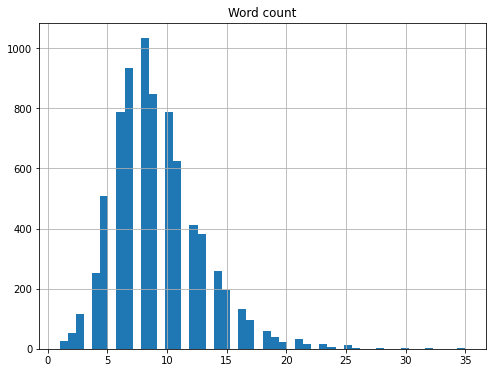

In [9]:
word_counts = df.groupby("id")["Text"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6))
word_counts.shape

In [10]:
MAX_SENTENCE = word_counts.max()[0]
print(f'Longest sentence contains {MAX_SENTENCE} words.')

Longest sentence contains 35 words.


In [11]:
tag_idx_dict = {tag: idx for idx, tag in enumerate(all_tags)}
idx_tag_dict = {idx: tag for idx, tag in enumerate(all_tags)}

tag_idx_dict

{'B-Amenity': 0,
 'B-Dish': 1,
 'I-Amenity': 2,
 'B-Rating': 3,
 'B-Restaurant_Name': 4,
 'I-Hours': 5,
 'I-Cuisine': 6,
 'I-Dish': 7,
 'B-Hours': 8,
 'B-Cuisine': 9,
 'I-Price': 10,
 'O': 11,
 'I-Location': 12,
 'B-Location': 13,
 'B-Price': 14,
 'I-Rating': 15,
 'I-Restaurant_Name': 16}

In [12]:
def to_tuples(data):
    iterator = zip(data["Text"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, tag) for word, tag in iterator]

sentences = df.groupby("id").apply(to_tuples).tolist()

print(sentences[0][:10])

[('2', 'B-Rating'), ('start', 'I-Rating'), ('restaurants', 'O'), ('with', 'O'), ('inside', 'B-Amenity'), ('dining', 'I-Amenity')]


In [13]:
df_idx = pd.DataFrame()

df_idx['invoice_id'] = list(set(df['id']))
df_idx['text_tag'] = sentences

In [14]:
df_idx.head()

,invoice_id,text_tag
0,0,"[(2, B-Rating), (start, I-Rating), (restaurant..."
1,1,"[(34, O)]"
2,2,"[(5, B-Rating), (star, I-Rating), (resturants,..."
3,3,"[(98, O), (hong, B-Restaurant_Name), (kong, I-..."
4,4,"[(a, O), (great, O), (lunch, O), (spot, O), (b..."


In [15]:
df_idx['text']=df_idx['text_tag'].apply(lambda text_tag:" ".join([str(s[0]) for s in text_tag]))
df_idx['tag']=df_idx['text_tag'].apply(lambda text_tag:" ".join([str(s[1]) for s in text_tag]))

In [16]:
df_idx.head()

,invoice_id,text_tag,text,tag
0,0,"[(2, B-Rating), (start, I-Rating), (restaurant...",2 start restaurants with inside dining,B-Rating I-Rating O O B-Amenity I-Amenity
1,1,"[(34, O)]",34,O
2,2,"[(5, B-Rating), (star, I-Rating), (resturants,...",5 star resturants in my town,B-Rating I-Rating O B-Location I-Location I-Lo...
3,3,"[(98, O), (hong, B-Restaurant_Name), (kong, I-...",98 hong kong restaurant reasonable prices,O B-Restaurant_Name I-Restaurant_Name O B-Price O
4,4,"[(a, O), (great, O), (lunch, O), (spot, O), (b...",a great lunch spot but open till 2 a m passims...,O O O O O B-Hours I-Hours I-Hours I-Hours I-Ho...


In [17]:
df_idx.shape

(7660, 4)

In [18]:
df_idx['tokenized_text']=df_idx['text'].apply(lambda x:x.split())
df_idx['tag_list']=df_idx['tag'].apply(lambda x:x.split())
df_idx.head()

,invoice_id,text_tag,text,tag,tokenized_text,tag_list
0,0,"[(2, B-Rating), (start, I-Rating), (restaurant...",2 start restaurants with inside dining,B-Rating I-Rating O O B-Amenity I-Amenity,"[2, start, restaurants, with, inside, dining]","[B-Rating, I-Rating, O, O, B-Amenity, I-Amenity]"
1,1,"[(34, O)]",34,O,[34],[O]
2,2,"[(5, B-Rating), (star, I-Rating), (resturants,...",5 star resturants in my town,B-Rating I-Rating O B-Location I-Location I-Lo...,"[5, star, resturants, in, my, town]","[B-Rating, I-Rating, O, B-Location, I-Location..."
3,3,"[(98, O), (hong, B-Restaurant_Name), (kong, I-...",98 hong kong restaurant reasonable prices,O B-Restaurant_Name I-Restaurant_Name O B-Price O,"[98, hong, kong, restaurant, reasonable, prices]","[O, B-Restaurant_Name, I-Restaurant_Name, O, B..."
4,4,"[(a, O), (great, O), (lunch, O), (spot, O), (b...",a great lunch spot but open till 2 a m passims...,O O O O O B-Hours I-Hours I-Hours I-Hours I-Ho...,"[a, great, lunch, spot, but, open, till, 2, a,...","[O, O, O, O, O, B-Hours, I-Hours, I-Hours, I-H..."


In [19]:
texts_list=df_idx['text'].tolist()
tags_list=df_idx['tag_list'].tolist()

In [20]:
tokenizer = Tokenizer(lower=False, filters='!?~[]()^_{"}\'%')
tokenizer.fit_on_texts(texts_list)
encoded_text_list = tokenizer.texts_to_sequences(texts_list)

print("Vocab size of Tokenizer ",len(tokenizer.word_index)+1)

Vocab size of Tokenizer  3805


In [21]:
encoded_tags_list = [[tag_idx_dict[w] for w in tag] for tag in tags_list]

In [22]:
padded_encoded_text_list = pad_sequences(maxlen=MAX_SENTENCE, sequences=encoded_text_list, padding="post", value=0)
padded_encoded_tags_list = pad_sequences(maxlen=MAX_SENTENCE, sequences=encoded_tags_list, padding="post", value=tag_idx_dict['O'])

In [23]:
dummy_tags = [to_categorical(i, num_classes=NUM_TAGS) for i in padded_encoded_tags_list]

In [24]:
# Train-val-test split
X, y = split_dataset(padded_encoded_text_list, dummy_tags)

train: 70%
val: 10%
test: 20%


In [25]:
model = create_model_bilstmcrf(MAX_SENTENCE, VOCAB_SIZE, NUM_TAGS)

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), 
                loss=SigmoidFocalCrossEntropy(), 
                metrics=['accuracy'])

history = model.fit(X['train'],
                    np.array(y['train']), 
                    validation_data=(X['val'], np.array(y['val'])),
                    batch_size=8,
                    callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
                    epochs=20)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 35)]              0         
                                                                 
 embedding (Embedding)       (None, 35, 50)            190250    
                                                                 
 bidirectional (Bidirectiona  (None, 35, 60)           19440     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 35, 60)            0         
                                                                 
 time_distributed (TimeDistr  (None, 35, 50)           3050      
 ibuted)                                                         
                                                                 
 crf (CRF)                   [(None, 35),              1190  

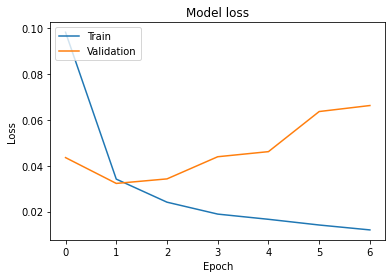

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

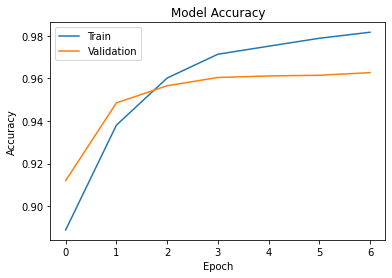

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
y_pred = model.predict(X['val'])

pred_index_array = np.argmax(y_pred, axis=-1)
val_index_array = np.argmax(y['val'], axis=-1)

real_tag, pred_tag = prepare_to_eval(idx_tag_dict, val_index_array, pred_index_array)

print(f'Accuracy: {accuracy_score(real_tag, pred_tag)}')
print(f'F1-score: {f1_score(real_tag, pred_tag)}')

24/24 [==============================] - 5s 26ms/step
Accuracy: 0.9627004848936964
F1-score: 0.6474683544303796


In [29]:
y_pred = model.predict(X['test'])

pred_index_array = np.argmax(y_pred, axis=-1)
test_index_array = np.argmax(y['test'], axis=-1)

real_tag, pred_tag = prepare_to_eval(idx_tag_dict, test_index_array, pred_index_array)

print(f'Accuracy: {accuracy_score(real_tag, pred_tag)}')
print(f'F1-score: {f1_score(real_tag, pred_tag)}')

48/48 [==============================] - 1s 23ms/step
Accuracy: 0.9659082431928385
F1-score: 0.6699890982712973


In [30]:
print(classification_report(real_tag, pred_tag, zero_division=0))

                 precision    recall  f1-score   support

        Amenity       0.51      0.62      0.56       500
        Cuisine       0.74      0.77      0.75       579
           Dish       0.59      0.66      0.62       311
          Hours       0.61      0.67      0.63       215
       Location       0.71      0.75      0.73       764
          Price       0.72      0.72      0.72       135
         Rating       0.62      0.73      0.67       222
Restaurant_Name       0.66      0.60      0.62       369

      micro avg       0.65      0.69      0.67      3095
      macro avg       0.64      0.69      0.66      3095
   weighted avg       0.65      0.69      0.67      3095

